In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.__version__

'2.1.0'

In [5]:
import glob
# import imageio  # To generate GIFs
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tqdm import tqdm
from tensorflow.keras import layers
import time
import pathlib

from IPython import display

# Import dataset

In [37]:
# TODO: Import own dataset of kidney stone
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

ks_dir_path_SEC = '../../dataset_calculs_classed/SEC'
ks_dir_path_SUR = '../../dataset_calculs_classed/SUR'

ks_dir_SEC = pathlib.Path(ks_dir_path_SEC)
ks_dir_SUR = pathlib.Path(ks_dir_path_SUR)

list_ds_SEC = tf.data.Dataset.list_files(str(ks_dir_SEC/'*/*'))
list_ds_SUR = tf.data.Dataset.list_files(str(ks_dir_SUR/'*/*'))

In [38]:
CLASS_NAMES_SEC = np.array([item.name for item in ks_dir_SEC.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES_SEC)

CLASS_NAMES_SUR = np.array([item.name for item in ks_dir_SUR.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES_SUR)

['Ia_SEC' 'Ib_SEC' 'Ic_SEC' 'Id_SEC' 'Ie_SEC' 'IIa_SEC' 'IIb_SEC'
 'IIIa_SEC' 'IIIb_SEC' 'IVa1_SEC' 'IVa2_SEC' 'IVb_SEC' 'IVc_SEC' 'IVd_SEC'
 'Va_SEC' 'VIa_SEC']
['Ia_SUR' 'Ib_SUR' 'Ic_SUR' 'Id_SUR' 'Ie_SUR' 'IIa_SUR' 'IIb_SUR'
 'IIIa_SUR' 'IIIb_SUR' 'IVa1_SUR' 'IVa2_SUR' 'IVb_SUR' 'IVc_SUR' 'IVd_SUR'
 'Va_SUR' 'VIa_SUR']


In [39]:
def show_batch(image_batch, label_batch, SEC=True):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if SEC:
            plt.title(CLASS_NAMES_SEC[label_batch[n]==1][0].title())
        else:
            plt.title(CLASS_NAMES_SUR[label_batch[n]==1][0].title())
        plt.axis('off')

In [40]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [41]:
def get_label(file_path, SEC):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if SEC:
        return parts[-2] == CLASS_NAMES_SEC
    else:
        return parts[-2] == CLASS_NAMES_SUR

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path, SEC=True):
    label = get_label(file_path, SEC)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def process_path_SEC(file_path):
    return process_path(file_path, SEC=True)

def process_path_SUR(file_path):
    return process_path(file_path, SEC=False)

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds_SEC = list_ds_SEC.map(process_path_SEC, num_parallel_calls=AUTOTUNE)
labeled_ds_SUR = list_ds_SUR.map(process_path_SUR, num_parallel_calls=AUTOTUNE)

In [43]:
for image, label in labeled_ds_SEC.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False  True False False
 False False False False]


In [44]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [46]:
train_SEC = prepare_for_training(labeled_ds_SEC)
image_batch, label_batch = next(iter(train_SEC))

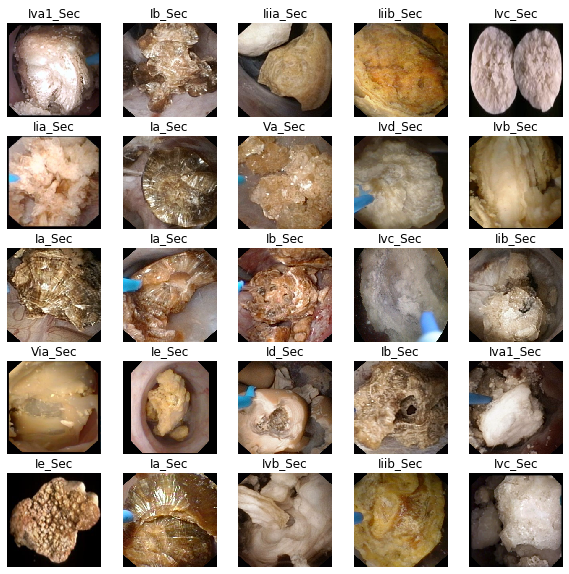

In [47]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Preprocessing

We need to make sure images in the dataset have shape of (*size*, *size*, channels).  
We also normalize pixels value to ease learning.

In [4]:
train_images.shape

(60000, 28, 28)

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # MNIST dataset doesn't have channel
train_images = train_images/255 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

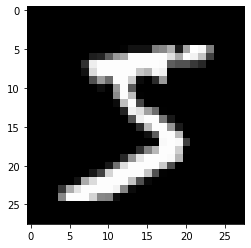

In [7]:
plt.imshow(train_images[0,:,:,0], cmap='gray')

## Generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

### Test Generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 3)


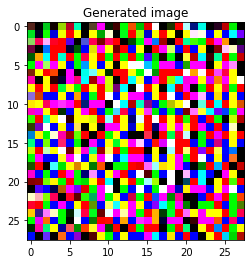

In [15]:
generator = make_generator_model()

noise = tf.random.uniform([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
generated_image *= 255
np.array(generated_image, np.int32)

# plt.figure()
# plt.title("Random noise")
# plt.imshow(np.random.rand(28, 28), cmap='gray')

plt.figure()
plt.title("Generated image")
plt.imshow(generated_image[0, :, :, :])#, cmap='gray')

In [16]:
print(generated_image)

tf.Tensor(
[[[[ 0.33948946  0.14412212  0.10679772]
   [-0.12603895 -0.84417254 -0.2017766 ]
   [-0.07795727  0.78892887  0.11118261]
   ...
   [ 0.73885083 -0.4487026  -0.35154778]
   [-0.11474378  0.952516   -0.48746687]
   [-0.42374942 -0.86671066 -1.2489874 ]]

  [[-0.6350593   0.88953495  0.12265297]
   [-0.37047026 -0.4834797   0.13216312]
   [ 0.06845187  2.4103315  -1.291334  ]
   ...
   [-0.05158261 -2.68882     4.639168  ]
   [-0.07063191  1.2063367   3.3795671 ]
   [ 0.44914243 -1.7294751   1.469073  ]]

  [[ 0.56006503  0.84926647  0.38383737]
   [ 2.8502495  -0.27930027  0.3464509 ]
   [ 0.99366724  0.6911601   1.1674602 ]
   ...
   [ 5.365974    0.5842038  -1.0119178 ]
   [-1.1019771  -1.1513785  -1.551967  ]
   [-5.0616326   0.09665334 -0.5179134 ]]

  ...

  [[-1.3363836   1.5834715  -0.147313  ]
   [ 0.9359415  -1.2871937   2.3048344 ]
   [ 1.2724926   0.42310855 -0.0956228 ]
   ...
   [-3.0108259  -1.6709464   6.6332955 ]
   [ 3.9431179  -0.49356103  0.44153196]
   [-

## Discriminator

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0033777]], shape=(1, 1), dtype=float32)


# Define loss and optimizer

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop

In [18]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    checkpoint.save(file_prefix = checkpoint_prefix)

In [29]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train

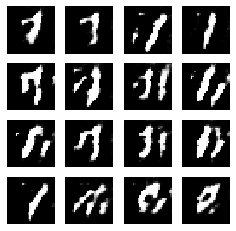

In [26]:
train(train_dataset, EPOCHS)

# Use classes

In [ ]:
class GAN:
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model()
        
    def load(self, model_path):
        